# Convolutional Networks

In [6]:
import torch
if torch.cuda.is_available():
  print("Successfully enabled CUDA processing")
else:
  print("CUDA processing not available. Things will be slow :-(")

Successfully enabled CUDA processing


## Dataset

In PyTorch, a dataset stores a list of input and target tensors $(X^n, T^n)$.
In case of **FashionMNIST** dataset, the inputs are $X^n \in \mathbb R^{28\times28\times1}$ and $T^n \in \{0,\ldots,9\}$.
More precisely, the data in the dataset is provided in form of `PIL.Image.Image`, which represents an image class with some more functionality, and pixel values in range $[0, 255]$.
In order to convert these images into `torch.Tensor`'s in range $[0,1]$, we can use the [ToTensor](https://pytorch.org/vision/main/generated/torchvision.transforms.ToTensor.html) transform.
Furthermore, in `PyTorch` batches are created from datasets using the [DataLoader](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) class.


### Task 1: Dataset Loading


Here, we use the [FashionMNIST dataset](https://pytorch.org/vision/stable/generated/torchvision.datasets.FashionMNIST.html#torchvision.datasets.FashionMNIST) of gray images for categorical classification.

Write a function that returns the training and the testing set of FashionMNIST, using the given transform.

In [7]:
import torch
import torchvision

def datasets(transform):
  root = './data'
  trainset = torchvision.datasets.FashionMNIST(root=root, train=True, download=True, transform=transform)
  testset = torchvision.datasets.FashionMNIST(root=root, train=False, download=True, transform=transform)

  return trainset, testset

### Test 1: Data Types

When we create the dataset with `transform=None`, all inputs shall be of type `PIL.Image.Image`, and all targets are integral.

In [8]:
import PIL
trainset, testset = datasets(transform=None)

for x,t in trainset:
  # check datatype of input x
  assert isinstance(x, PIL.Image.Image)
  # check datatype of target t
  assert isinstance(t, int)

### Task 2: Data Visulization
Create the dataset with `transform=None`. Plot 40 images of trainset using `matplotlib`.

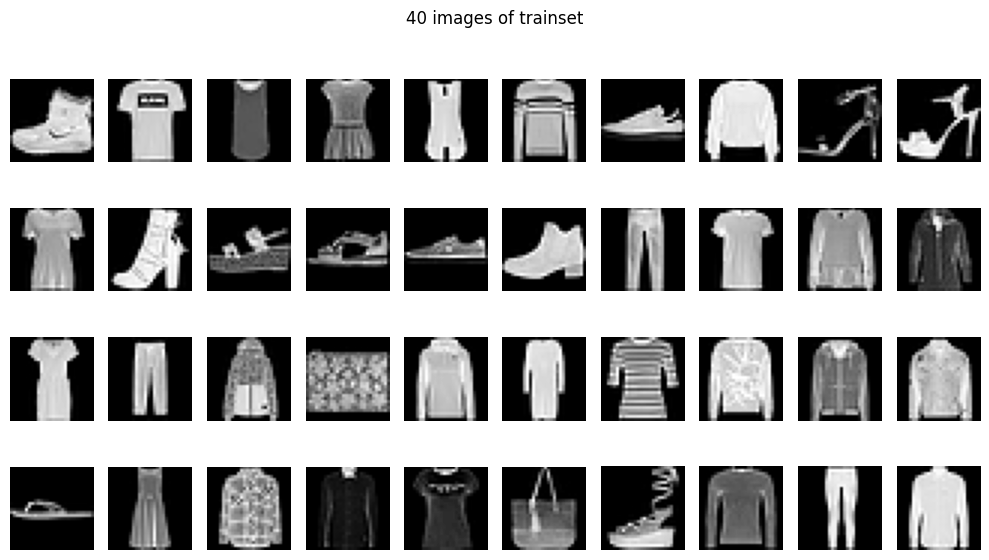

In [9]:
# plot images
trainset, testset = datasets(transform=None)

from matplotlib import pyplot
import numpy as np
pyplot.rcParams['image.cmap'] = 'gray'

figsize = (10,6)
fig, axes = pyplot.subplots(4, 10, figsize=figsize)

index=0
for i in range(4):
    for j in range(10):
      if index >= len(trainset):    #check if reached the end of the dataset
        break
      img, _ = trainset[index]     #get image and label
      img = np.asarray(img)   #convert image to NumPy array

      # anything else?

      axes[i][j].imshow(img)
      axes[i][j].axis("off")
      index+=1
fig.suptitle('40 images of trainset', fontsize=12)
pyplot.tight_layout()
pyplot.show()

### Task 3: Data Loaders


Create the dataset with transform `ToTensor`. Create two data loaders, one for the training set and one for the testing set. The training batch size should be $B=512$, for the testing set, you can select any batch size of your choice.


In [10]:
from torchvision import transforms
transform = transforms.ToTensor()
trainset, testset = datasets(transform=transform)

B = 512
trainloader = torch.utils.data.DataLoader(trainset, batch_size=B, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=B, shuffle=False)
print(f"Train data loader size: {len(trainloader)} batches")
print(f"Test data loader size: {len(testloader)} batches")

Train data loader size: 118 batches
Test data loader size: 20 batches


### Test 3: Batches

Check that all batches generated by the training set data loader have the batch size of $B$ -- except for the last batch, which you need to compute by yourself (you might want to make use of the modulo operator `%`).

Afterward, we check that all inputs and targets are of type `torch.Tensor`, that all input values are in range $[0,1]$ and that all target values are in range $[0,9]$.

In [11]:
# compute the size of last batch
dataset_size = len(trainset)
last_batch = dataset_size % B if dataset_size % B != 0 else B

for x,t in trainloader:
  # check datatype, size and content of x
  assert isinstance(x, torch.Tensor)
  assert(torch.all(x >= 0)) and torch.all(x <= 1)
  assert len(x)==B or len(x) == last_batch

  # check datatype, size and content of t
  assert isinstance(t, torch.Tensor)
  assert(torch.all(t >= 0)) and torch.all(t <= 9)
  assert len(t)==B or len(t) == last_batch

## Networks
As last week, we will rely on `torch.nn.Sequential` to create networks with particular lists of consecutive layers.
Particularly, we will investigate two different versions of networks, one fully-connected network and one convolutional network, with the same number of learnable layers.

### Task 4: Fully-Connected Network


Implement a function that returns a three-layer fully-connected network in pytorch.
Use the logistic function $\sigma$ as activation function between the two fully-connected layers, and provide the possibility to change the number of inputs $D$, the number of hidden neurons $K$ and the number of outputs $O$.
Use the following layers:

1. A `torch.nn.Flatten` layer to turn the $28\times28$ pixel image (2D) into a $28*28$ pixel vector (1D)
2. A fully-connected layer with D input neurons and K1 outputs.
3. A `Sigmoid` activation function.
4. A fully-connected layer with K1 input neurons and K2 outputs.
5. A `Sigmoid`activation function.
6. A fully-connected layer with K2 input neurons and O outputs.

In [12]:
def fully_connected(D, K1, K2, O):
  return torch.nn.Sequential(
    torch.nn.Flatten(),
    torch.nn.Linear(D, K1),
    torch.nn.Sigmoid(),
    torch.nn.Linear(K1, K2),
    torch.nn.Sigmoid(),
    torch.nn.Linear(K2, O)
  )

### Task 5: Convolutions Output (theoretical question)

Consider the network as defined in Task 6.
Assume that the input is a $28\times28$ grayscale image.
How many hidden neurons do we need in the final fully-connected layer for a given number $Q_2$ of output channels of the second convolution?

(Write steps of computation.)



$Q2\times5\times5 = Q2\times25$ hidden neurons are needed in the final fully-connected layer.

### Task 6: Convolutional Network

Implement a function that generates a convolutional network with the following layers:

1. A [2D convolutional layer](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html) with $Q_1$ channels, kernel size $7\times7$, stride 1 and padding 0.
2. A [2D maximum pooling](https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html) with pooling size $2\times2$ and stride 2.
3. A `Sigmoid` activation function.
4. A 2D convolutional layer with $Q_2$ channels, kernel size $5\times5$, stride 1 and padding 2.
5. A 2D maximum pooling with pooling size $2\times2$ and stride 2.
6. A `Sigmoid` activation function.
7. A flattening layer to turn the 3D feature map into a 1D vector.
8. A fully-connected layer with the appropriate number of inputs and $O$ outputs.

In [13]:
def convolutional(Q1, Q2, O):
  return torch.nn.Sequential(
    torch.nn.Conv2d(1, Q1, (7,7), stride=1, padding=0),
    torch.nn.MaxPool2d((2,2), stride=2),
    torch.nn.Sigmoid(),
    torch.nn.Conv2d(Q1, Q2, (5,5), stride=1, padding=2),
    torch.nn.MaxPool2d((2,2), stride=2),
    torch.nn.Sigmoid(),
    torch.nn.Flatten(),
    # torch.nn.Linear(Q2*7*7, O)
    torch.nn.Linear(Q2*5*5, O)
  )

## Network Training
For training and evaluating the network, we rely on standard functionality in PyTorch.
We use the standard [categorical cross-entropy loss](https://pytorch.org/docs/stable/nn.html#loss-functions) together with a [stochastic gradient descent](https://pytorch.org/docs/stable/generated/torch.optim.SGD.html) optimizer.
For training, we use the batched implementation of the dataset, for which we perform one update step for each training batch.
After having gone through the full training dataset, we compute accuracy and loss values for the testing set (we simply make use of the testing set for validation).


### Task 7: Training and Validation Loop

Implement a function that takes the network, the number of epochs, and the learning rate.
Select the correct loss function for categorical classification and SGD optimizer.
Iterate the following steps for the given number of epochs:

1. Train the network with all batches of the training data.
2. Compute the testing set loss and testing set accuracy.
3. Store both in a list.

What do we need to take care of?

Finally, return the lists of validation losses and accuracies.

In [14]:
def train(network, epochs, eta, momentum):
  # select loss function and optimizer
  loss = torch.nn.CrossEntropyLoss()
  optimizer = torch.optim.SGD(network.parameters(), lr=eta, momentum=momentum)

  # instantiate the correct device
  device = torch.device("cuda")
  network = network.to(device)

  # collect loss values and accuracies over the training epochs
  val_loss, val_acc = [], []

  for epoch in range(epochs):
    # train network on training data
    for x,t in trainloader:
      # put data to device
      x = x.to(device)
      t = t.to(device)
      # train
      optimizer.zero_grad()
      y = network(x)
      l = loss(y, t)
      l.backward()
      optimizer.step()

    # test network on test data
    with torch.no_grad():
      total_loss, total_correct = 0, 0
      for x,t in testloader:
        # put data to device
        x = x.to(device)
        t = t.to(device)
        # compute validation loss
        y = network(x)
        l = loss(y, t)
        total_loss += l.item()
        # compute validation accuracy
        predicted = torch.argmax(y, dim=1)
        total_correct += torch.sum((predicted == t)).item()

      #calculate average validation loss and accuracy per epoch
      val_loss.append(total_loss / len(testset))
      val_acc.append(total_correct / len(testset))
      if(epoch % 4 == 0):
        print(f"Epoch:{epoch}, Acc:{total_correct / len(testset)}")
  # return loss and accuracy values
  return val_loss, val_acc

### Task 8: Fully-Connected Training

Create a fully-connected network with $K1=128$, $K2=64$ hidden and $O=10$ output neurons.
Train the network for 100 epochs with $\eta=0.01$, `momentum=0.9` and store the obtained test losses and accuracies (which will take up to 15 - 20 minutes).

In [15]:
fc = fully_connected(D=28*28, K1=128, K2=64, O=10)
fc_loss, fc_acc = train(fc, epochs=100, eta=0.01, momentum=0.9)

Epoch:0, Acc:0.1853
Epoch:4, Acc:0.5576
Epoch:8, Acc:0.6368
Epoch:12, Acc:0.7236
Epoch:16, Acc:0.7474
Epoch:20, Acc:0.7613
Epoch:24, Acc:0.776
Epoch:28, Acc:0.7931
Epoch:32, Acc:0.8034
Epoch:36, Acc:0.8107
Epoch:40, Acc:0.8183
Epoch:44, Acc:0.8235
Epoch:48, Acc:0.8261
Epoch:52, Acc:0.8294
Epoch:56, Acc:0.8324
Epoch:60, Acc:0.8346
Epoch:64, Acc:0.836
Epoch:68, Acc:0.8405
Epoch:72, Acc:0.8438
Epoch:76, Acc:0.8435
Epoch:80, Acc:0.8473
Epoch:84, Acc:0.8486
Epoch:88, Acc:0.8485
Epoch:92, Acc:0.8509
Epoch:96, Acc:0.8521


### Task 8: Convolutional Training


Create a convolutional network with $Q_1=16$ and $Q_2=16$ convolutional channels and $O=10$ output neurons.
Train the network for 100 epochs with $\eta=0.01$, momentum $=0.9$ and store the obtained test losses and accuracies, which will take up to 15 - 20 minutes.

In [16]:
cv = convolutional(Q1=16, Q2=16, O=10)
cv_loss, cv_acc = train(cv, epochs=100, eta=0.01, momentum=0.9)

Epoch:0, Acc:0.2167
Epoch:4, Acc:0.7012
Epoch:8, Acc:0.7332
Epoch:12, Acc:0.749
Epoch:16, Acc:0.7643
Epoch:20, Acc:0.7761
Epoch:24, Acc:0.791
Epoch:28, Acc:0.7975
Epoch:32, Acc:0.8081
Epoch:36, Acc:0.8142
Epoch:40, Acc:0.8197
Epoch:44, Acc:0.8278
Epoch:48, Acc:0.8316
Epoch:52, Acc:0.8356
Epoch:56, Acc:0.8404
Epoch:60, Acc:0.8407
Epoch:64, Acc:0.8454
Epoch:68, Acc:0.8477
Epoch:72, Acc:0.8517
Epoch:76, Acc:0.8527
Epoch:80, Acc:0.8533
Epoch:84, Acc:0.8526
Epoch:88, Acc:0.858
Epoch:92, Acc:0.8581
Epoch:96, Acc:0.8605


### Task 9: Plotting

Plot the two lists of loss values in one plot. Plot the two lists of accuracy values into another plot.

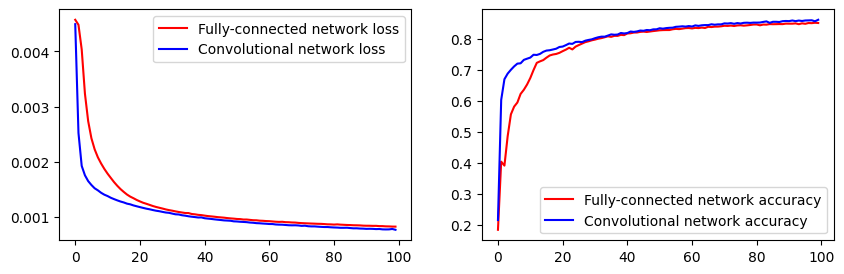

In [17]:
from matplotlib import pyplot
pyplot.figure(figsize=(10,3))
ax = pyplot.subplot(121)
# plot loss values of FC and CV network over epochs
ax.plot(fc_loss, 'r-', label="Fully-connected network loss")
ax.plot(cv_loss, 'b-', label="Convolutional network loss")
ax.legend()

ax = pyplot.subplot(122)
# plot accuracy values of FC and CV network over epochs
ax.plot(fc_acc, 'r-', label="Fully-connected network accuracy")
ax.plot(cv_acc, 'b-', label="Convolutional network accuracy")
ax.legend()

### Task 10: Learnable Parameters

Estimate roughly how many learnable parameters the two networks have by analytically computing and adding the number of parameters in each layer.

Fully-connected Network:
- first fully-connected layer: $ K1\times(D+1) = 128\times(28\times28+1) = 100480 $
- second fully-connected layer: $ K2\times(K1+1) = 64\times(128+1) = 8256 $
- third fully-connected layer: $ O\times(K2+1) = 10\times(64+1) = 650 $
- total: $100480+8256+650=109386$

Convolutional Network:
- first convolutional layer: $ Q1\times(1\times kernel\_size +1) = 16\times(1\times7\times7+1) = 800 $
- second convolutional layer: $ Q2\times(Q1\times kernel\_size +1) = 16\times(16\times5\times5+1) = 6416 $
- fully-connected layer: $O\times(Q2\times5\times5+1)=10\times(400+1)=4010$
- total: $800+6416+4010=11226$



Now, compute the number of parameters in the networks by summing the number of parameters in each layer using `pytorch` functionality.
You can use the `numel()` function from a `torch.Tensor` to provide the number of (learnable) parameters stored in a tensor.
How do you obtain this list of all learnable parameters from a `pytorch` [Module](https://pytorch.org/docs/stable/generated/torch.nn.Module.html)?

In [18]:
def parameter_count(network):
  return sum(p.numel() for p in network.parameters())

print("Fully-connected Network:", parameter_count(fc))
print("Convolutional Network:", parameter_count(cv))

Fully-connected Network: 109386
Convolutional Network: 11226
